<a href="https://colab.research.google.com/github/OumJeb/ISIE_project/blob/master/AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch_geometric

In [3]:
import torch
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [4]:
# Load the data from Google Drive
term_df = pd.read_csv("/content/drive/MyDrive/term_df.csv")
result_df = pd.read_csv("/content/drive/MyDrive/result_df.csv")

# Dont use

In [ ]:
# Step 1: Create a mapping from term to node index
terms = pd.concat([result_df['node_1'], result_df['node_2']]).unique()
term_to_index = {term: idx for idx, term in enumerate(terms)}

In [ ]:
# Step 2: Convert term definitions into features (using TF-IDF for simplicity)
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(term_df['definition'].fillna('')).toarray()

In [ ]:
# Create a feature matrix where each row corresponds to a term
features = np.zeros((len(terms), tfidf_features.shape[1]))
for idx, term in enumerate(term_df['term']):
    if term in term_to_index:
        term_idx = term_to_index[term]
        features[term_idx] = tfidf_features[idx]

In [ ]:
# Convert features to a tensor
x = torch.tensor(features, dtype=torch.float)

In [ ]:
# Step 3: Create the edge index and encode the relationship types
edges = []
edge_features = []
label_encoder = LabelEncoder()

# Encode the relationship types (edge column)
encoded_relationships = label_encoder.fit_transform(result_df['edge'])

for _, row in result_df.iterrows():
    if row['node_1'] in term_to_index and row['node_2'] in term_to_index:
        node1_idx = term_to_index[row['node_1']]
        node2_idx = term_to_index[row['node_2']]
        edges.append([node1_idx, node2_idx])
        edge_features.append(encoded_relationships[_])

In [ ]:
# Convert edge list and edge features to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)

In [ ]:
# Step 4: Create the PyTorch Geometric Data object with edge attributes
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
# Split the data into train/test sets
train_mask, test_mask = train_test_split(range(num_nodes), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

In [ ]:
# Step 5: Define a GAT model that uses edge attributes
class GATWithEdgeFeatures(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=2):
        super(GATWithEdgeFeatures, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6, edge_dim=1)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1)

In [ ]:
# Step 6: Initialize and train the GAT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATWithEdgeFeatures(input_dim=data.num_features, hidden_dim=64, output_dim=10).to(device)  # Adjust output_dim as needed
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training and evaluation functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    test_pred = pred[test_mask].cpu().numpy()
    test_true = data.y[test_mask].cpu().numpy()
    acc = accuracy_score(test_true, test_pred)
    precision = precision_score(test_true, test_pred, average='weighted')
    recall = recall_score(test_true, test_pred, average='weighted')
    f1 = f1_score(test_true, test_pred, average='weighted')
    return acc, precision, recall, f1

In [ ]:
# Training loop with visualization
train_losses = []
test_accuracies = []

for epoch in range(200):
    loss = train()
    train_losses.append(loss)
    acc, precision, recall, f1 = test()
    test_accuracies.append(acc)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Epoch 1, Loss: 2.3282, Test Accuracy: 0.1000, Precision: 0.0941, Recall: 0.1000, F1-Score: 0.0851
Epoch 2, Loss: 2.3151, Test Accuracy: 0.1000, Precision: 0.2189, Recall: 0.1000, F1-Score: 0.0949
Epoch 3, Loss: 2.3030, Test Accuracy: 0.0667, Precision: 0.1196, Recall: 0.0667, F1-Score: 0.0371
Epoch 4, Loss: 2.2955, Test Accuracy: 0.0917, Precision: 0.0763, Recall: 0.0917, F1-Score: 0.0623
Epoch 5, Loss: 2.2896, Test Accuracy: 0.0917, Precision: 0.0656, Recall: 0.0917, F1-Score: 0.0546
Epoch 6, Loss: 2.2952, Test Accuracy: 0.0833, Precision: 0.0601, Recall: 0.0833, F1-Score: 0.0497
Epoch 7, Loss: 2.2622, Test Accuracy: 0.0833, Precision: 0.0598, Recall: 0.0833, F1-Score: 0.0512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 8, Loss: 2.2543, Test Accuracy: 0.1167, Precision: 0.1261, Recall: 0.1167, F1-Score: 0.0840
Epoch 9, Loss: 2.2658, Test Accuracy: 0.1250, Precision: 0.1249, Recall: 0.1250, F1-Score: 0.0924
Epoch 10, Loss: 2.2730, Test Accuracy: 0.1250, Precision: 0.1115, Recall: 0.1250, F1-Score: 0.0955
Epoch 11, Loss: 2.2723, Test Accuracy: 0.1083, Precision: 0.1028, Recall: 0.1083, F1-Score: 0.0892
Epoch 12, Loss: 2.2444, Test Accuracy: 0.0833, Precision: 0.0828, Recall: 0.0833, F1-Score: 0.0704
Epoch 13, Loss: 2.2410, Test Accuracy: 0.0750, Precision: 0.0776, Recall: 0.0750, F1-Score: 0.0659
Epoch 14, Loss: 2.2250, Test Accuracy: 0.0750, Precision: 0.0744, Recall: 0.0750, F1-Score: 0.0651
Epoch 15, Loss: 2.2248, Test Accuracy: 0.0750, Precision: 0.0756, Recall: 0.0750, F1-Score: 0.0666
Epoch 16, Loss: 2.2187, Test Accuracy: 0.0667, Precision: 0.0737, Recall: 0.0667, F1-Score: 0.0626
Epoch 17, Loss: 2.2213, Test Accuracy: 0.0750, Precision: 0.0772, Recall: 0.0750, F1-Score: 0.0712
Epoch 18, Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22, Loss: 2.1912, Test Accuracy: 0.0667, Precision: 0.0790, Recall: 0.0667, F1-Score: 0.0641
Epoch 23, Loss: 2.2132, Test Accuracy: 0.0667, Precision: 0.0784, Recall: 0.0667, F1-Score: 0.0637
Epoch 24, Loss: 2.1916, Test Accuracy: 0.0667, Precision: 0.0775, Recall: 0.0667, F1-Score: 0.0630
Epoch 25, Loss: 2.1892, Test Accuracy: 0.0667, Precision: 0.0802, Recall: 0.0667, F1-Score: 0.0635
Epoch 26, Loss: 2.2160, Test Accuracy: 0.0667, Precision: 0.0895, Recall: 0.0667, F1-Score: 0.0701
Epoch 27, Loss: 2.1995, Test Accuracy: 0.0667, Precision: 0.0851, Recall: 0.0667, F1-Score: 0.0693
Epoch 28, Loss: 2.1778, Test Accuracy: 0.0667, Precision: 0.0930, Recall: 0.0667, F1-Score: 0.0677
Epoch 29, Loss: 2.1751, Test Accuracy: 0.0667, Precision: 0.0930, Recall: 0.0667, F1-Score: 0.0677
Epoch 30, Loss: 2.1788, Test Accuracy: 0.0583, Precision: 0.0600, Recall: 0.0583, F1-Score: 0.0538
Epoch 31, Loss: 2.1193, Test Accuracy: 0.0583, Precision: 0.0567, Recall: 0.0583, F1-Score: 0.0526
Epoch 32, 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 43, Loss: 2.1472, Test Accuracy: 0.0667, Precision: 0.0839, Recall: 0.0667, F1-Score: 0.0718
Epoch 44, Loss: 2.1603, Test Accuracy: 0.0750, Precision: 0.0902, Recall: 0.0750, F1-Score: 0.0791
Epoch 45, Loss: 2.1238, Test Accuracy: 0.0750, Precision: 0.0915, Recall: 0.0750, F1-Score: 0.0796
Epoch 46, Loss: 2.1176, Test Accuracy: 0.0833, Precision: 0.0981, Recall: 0.0833, F1-Score: 0.0858
Epoch 47, Loss: 2.0913, Test Accuracy: 0.0833, Precision: 0.0971, Recall: 0.0833, F1-Score: 0.0852
Epoch 48, Loss: 2.1726, Test Accuracy: 0.0750, Precision: 0.0940, Recall: 0.0750, F1-Score: 0.0782


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 49, Loss: 2.1018, Test Accuracy: 0.0833, Precision: 0.1070, Recall: 0.0833, F1-Score: 0.0870
Epoch 50, Loss: 2.1449, Test Accuracy: 0.0833, Precision: 0.1020, Recall: 0.0833, F1-Score: 0.0826
Epoch 51, Loss: 2.1712, Test Accuracy: 0.0917, Precision: 0.1382, Recall: 0.0917, F1-Score: 0.0939
Epoch 52, Loss: 2.1309, Test Accuracy: 0.0833, Precision: 0.1299, Recall: 0.0833, F1-Score: 0.0843
Epoch 53, Loss: 2.1188, Test Accuracy: 0.0750, Precision: 0.1264, Recall: 0.0750, F1-Score: 0.0798
Epoch 54, Loss: 2.0990, Test Accuracy: 0.0750, Precision: 0.0959, Recall: 0.0750, F1-Score: 0.0691
Epoch 55, Loss: 2.1259, Test Accuracy: 0.0583, Precision: 0.0827, Recall: 0.0583, F1-Score: 0.0581
Epoch 56, Loss: 2.0730, Test Accuracy: 0.0667, Precision: 0.1115, Recall: 0.0667, F1-Score: 0.0707
Epoch 57, Loss: 2.1119, Test Accuracy: 0.0750, Precision: 0.1068, Recall: 0.0750, F1-Score: 0.0763
Epoch 58, Loss: 2.0509, Test Accuracy: 0.0833, Precision: 0.1074, Recall: 0.0833, F1-Score: 0.0879
Epoch 59, 

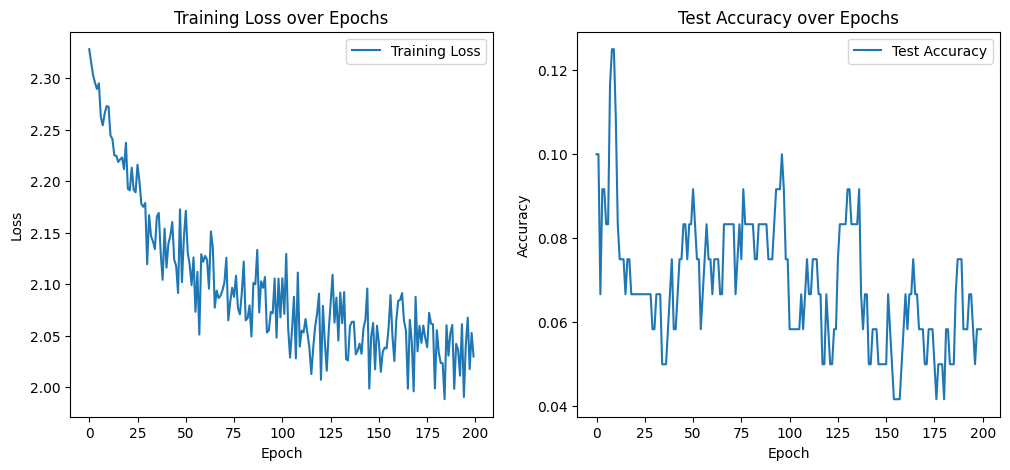

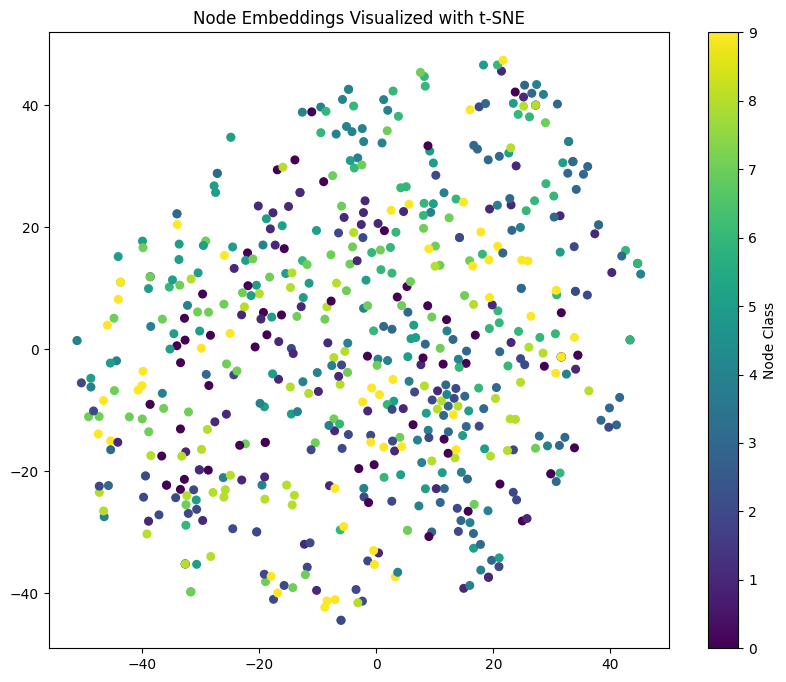

In [ ]:
# Step 7: Visualization of training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

# Step 8: Visualize the learned node embeddings using t-SNE
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr).cpu().numpy()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(out)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=data.y.cpu().numpy(), cmap='viridis', s=30)
plt.colorbar(label='Node Class')
plt.title('Node Embeddings Visualized with t-SNE')
plt.show()

Epoch 1, Loss: 1.3903
Epoch 2, Loss: 1.3704
Epoch 3, Loss: 1.3462
Epoch 4, Loss: 1.3195
Epoch 5, Loss: 1.3078
Epoch 6, Loss: 1.2819
Epoch 7, Loss: 1.2595
Epoch 8, Loss: 1.2276
Epoch 9, Loss: 1.1950
Epoch 10, Loss: 1.1756
Epoch 11, Loss: 1.1643
Epoch 12, Loss: 1.1176
Epoch 13, Loss: 1.1191
Epoch 14, Loss: 1.0805
Epoch 15, Loss: 1.0960
Epoch 16, Loss: 1.0863
Epoch 17, Loss: 1.0998
Epoch 18, Loss: 1.1018
Epoch 19, Loss: 1.0954
Epoch 20, Loss: 1.0755
Epoch 21, Loss: 1.0417
Epoch 22, Loss: 1.0406
Epoch 23, Loss: 1.0440
Epoch 24, Loss: 1.0467
Epoch 25, Loss: 1.0373
Epoch 26, Loss: 1.0277
Epoch 27, Loss: 0.9912
Epoch 28, Loss: 1.0248
Epoch 29, Loss: 1.0055
Epoch 30, Loss: 0.9964
Epoch 31, Loss: 0.9785
Epoch 32, Loss: 0.9739
Epoch 33, Loss: 0.9726
Epoch 34, Loss: 0.9768
Epoch 35, Loss: 0.9455
Epoch 36, Loss: 0.9828
Epoch 37, Loss: 0.9573
Epoch 38, Loss: 0.9555
Epoch 39, Loss: 0.9648
Epoch 40, Loss: 0.9453
Epoch 41, Loss: 0.9281
Epoch 42, Loss: 0.9636
Epoch 43, Loss: 0.9488
Epoch 44, Loss: 0.90

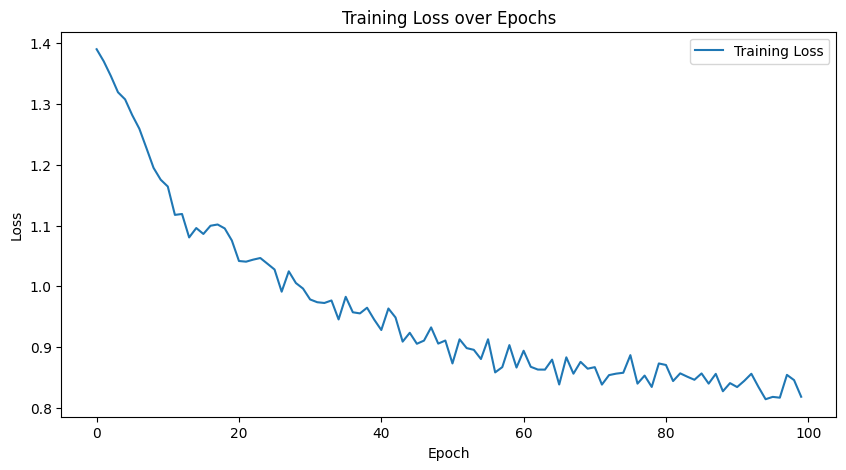

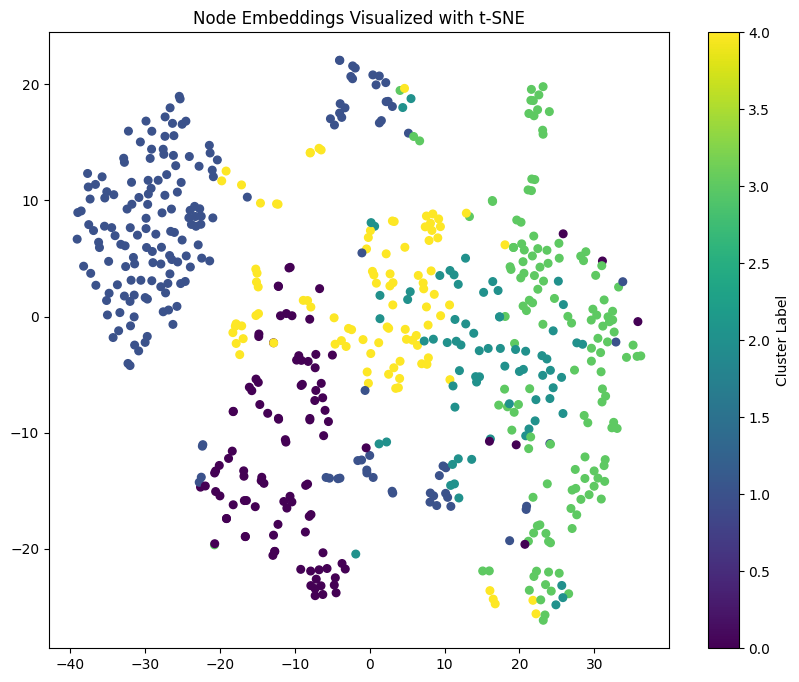

In [ ]:
import torch
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling

# Step 1: Load the data from the CSV files


# Step 2: Create a mapping from term to node index
terms = pd.concat([result_df['node_1'], result_df['node_2']]).unique()
term_to_index = {term: idx for idx, term in enumerate(terms)}

# Step 3: Convert term definitions into features using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(term_df['definition'].fillna('')).toarray()

# Create a feature matrix where each row corresponds to a term
features = np.zeros((len(terms), tfidf_features.shape[1]))
for idx, term in enumerate(term_df['term']):
    if term in term_to_index:
        term_idx = term_to_index[term]
        features[term_idx] = tfidf_features[idx]

# Convert features to a tensor
x = torch.tensor(features, dtype=torch.float)

# Step 4: Create the edge index and encode the relationship types
edges = []
edge_features = []
label_encoder = LabelEncoder()

# Encode the relationship types (edge column)
encoded_relationships = label_encoder.fit_transform(result_df['edge'])

for idx, row in result_df.iterrows():
    if row['node_1'] in term_to_index and row['node_2'] in term_to_index:
        node1_idx = term_to_index[row['node_1']]
        node2_idx = term_to_index[row['node_2']]
        edges.append([node1_idx, node2_idx])
        edge_features.append(encoded_relationships[idx])  # Add the encoded relationship type

# Convert edge list and edge features to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)  # Edge features as a tensor

# Step 5: Create the PyTorch Geometric Data object with edge attributes
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Step 6: Split the data using RandomLinkSplit
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=True)
train_data, val_data, test_data = transform(data)

# Step 7: Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # First GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GraphSAGE layer
        x = self.conv2(x, edge_index)
        return x

# Step 8: Initialize the GraphSAGE model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(input_dim=data.num_features, hidden_dim=64, output_dim=32).to(device)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training function for GraphSAGE
def train():
    model.train()
    optimizer.zero_grad()
    # Use positive training edges
    z = model(train_data.x, train_data.edge_index)
    # Predict on positive training edges
    pos_pred = (z[train_data.edge_index[0]] * z[train_data.edge_index[1]]).sum(dim=1)
    # Sample negative edges for training
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_index.size(1)
    )
    # Predict on negative training edges
    neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    # Compute binary cross-entropy loss
    pos_loss = -torch.log(torch.sigmoid(pos_pred) + 1e-15).mean()
    neg_loss = -torch.log(1 - torch.sigmoid(neg_pred) + 1e-15).mean()
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
train_losses = []

for epoch in range(100):
    loss = train()
    acc, precision, recall, f1 = test()
    test_accuracies.append(acc)
    train_losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Step 9: Evaluation on the test set
model.eval()
with torch.no_grad():
    z = model(test_data.x, test_data.edge_index)
    # Embeddings for evaluation
    embeddings = z.cpu().numpy()

# Apply K-Means clustering to the learned embeddings
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(embeddings)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f'Silhouette Score for the learned embeddings: {silhouette_avg:.4f}')

# Visualization of training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='viridis', s=30)
plt.colorbar(label='Cluster Label')
plt.title('Node Embeddings Visualized with t-SNE')
plt.show()


In [ ]:
# Group nodes by their cluster label
clusters = {}
for idx, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(terms[idx])

# Print out the terms in each cluster
for cluster, nodes in clusters.items():
    print(f"Cluster {cluster}:")
    print(", ".join(nodes[:10]))  # Print the first 10 terms in the cluster
    print("...")


Cluster 2:
project management institute (pmi) standards and guideline publications, tailoring projects, project performance domains, tailoring, models, methods, and artifacts, project environment, project management principles, project manager, stakeholder performance domain, team performance domain
...
Cluster 0:
managing change in organizations, accuracy, governance of portfolios, programs, and projects, subsidiary programs, product, accountability, business need, project justification, technological innovation, risk management plan
...
Cluster 1:
process-based standard, pmistandards+, cost-benefit analysis, ongoing improvement, project management office, pmo functions, process assets, governance documentation, data assets, knowledge assets
...
Cluster 3:
project management body of knowledge (pmbok), project teams, purpose of the standard for project management, consensus standards development process, delivery cadence, planning performance domain, development approach, predictive li

Epoch 1, Loss: 0.0412
Epoch 2, Loss: 0.0316
Epoch 3, Loss: 0.0289
Epoch 4, Loss: 0.0217
Epoch 5, Loss: 0.0194
Epoch 6, Loss: 0.0190
Epoch 7, Loss: 0.0166
Epoch 8, Loss: 0.0152
Epoch 9, Loss: 0.0124
Epoch 10, Loss: 0.0124
Epoch 11, Loss: 0.0116
Epoch 12, Loss: 0.0106
Epoch 13, Loss: 0.0101
Epoch 14, Loss: 0.0097
Epoch 15, Loss: 0.0093
Epoch 16, Loss: 0.0090
Epoch 17, Loss: 0.0088
Epoch 18, Loss: 0.0086
Epoch 19, Loss: 0.0085
Epoch 20, Loss: 0.0083
Epoch 21, Loss: 0.0081
Epoch 22, Loss: 0.0081
Epoch 23, Loss: 0.0080
Epoch 24, Loss: 0.0080
Epoch 25, Loss: 0.0079
Epoch 26, Loss: 0.0079
Epoch 27, Loss: 0.0079
Epoch 28, Loss: 0.0079
Epoch 29, Loss: 0.0079
Epoch 30, Loss: 0.0079
Epoch 31, Loss: 0.0079
Epoch 32, Loss: 0.0079
Epoch 33, Loss: 0.0079
Epoch 34, Loss: 0.0078
Epoch 35, Loss: 0.0079
Epoch 36, Loss: 0.0078
Epoch 37, Loss: 0.0079
Epoch 38, Loss: 0.0079
Epoch 39, Loss: 0.0079
Epoch 40, Loss: 0.0079
Epoch 41, Loss: 0.0079
Epoch 42, Loss: 0.0079
Epoch 43, Loss: 0.0079
Epoch 44, Loss: 0.00

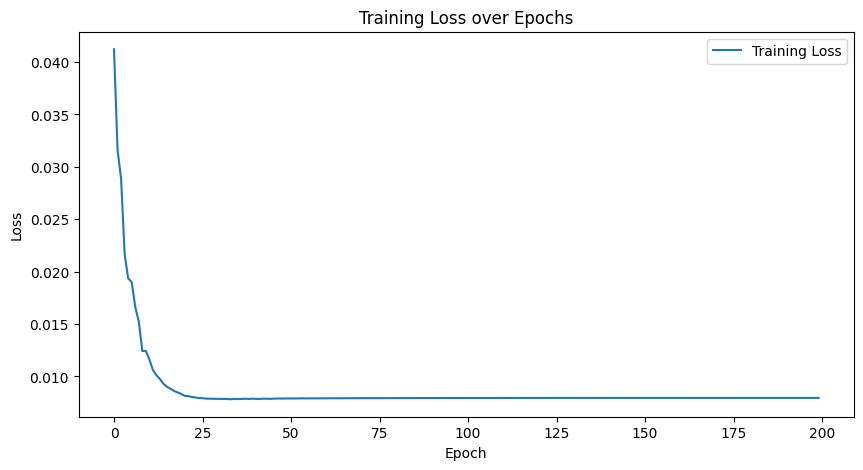

<ipython-input-9-a1294fcf6370>:114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)


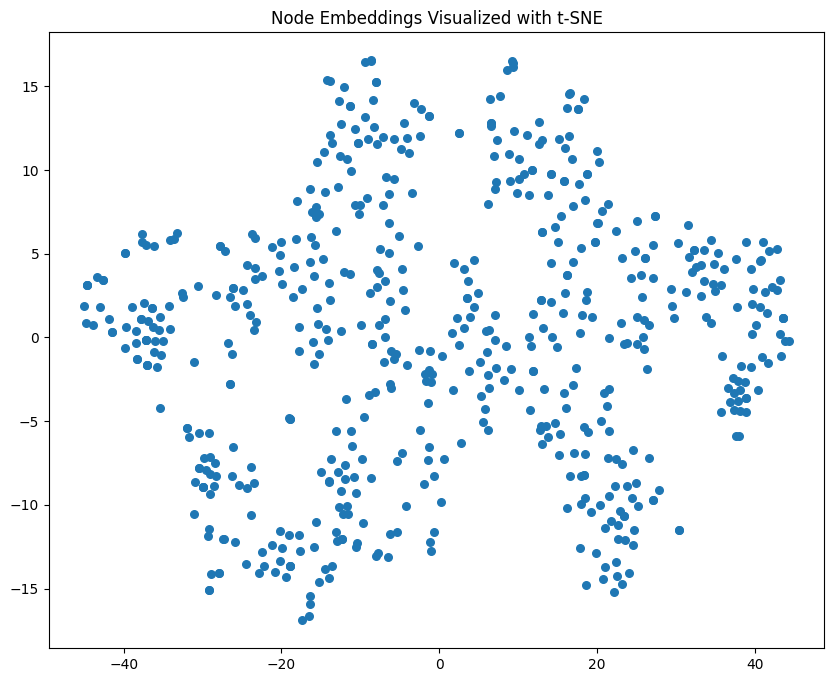

In [9]:
import torch
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 1: Create a mapping from term to node index
terms = pd.concat([result_df['node_1'], result_df['node_2']]).unique()
term_to_index = {term: idx for idx, term in enumerate(terms)}

# Step 2: Convert term definitions into features (using TF-IDF for simplicity)
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(term_df['definition'].fillna('')).toarray()

# Create a feature matrix where each row corresponds to a term
features = np.zeros((len(terms), tfidf_features.shape[1]))
for idx, term in enumerate(term_df['term']):
    if term in term_to_index:
        term_idx = term_to_index[term]
        features[term_idx] = tfidf_features[idx]

# Convert features to a tensor
x = torch.tensor(features, dtype=torch.float)

# Step 3: Create the edge index and encode the relationship types
edges = []
edge_features = []
label_encoder = LabelEncoder()

# Encode the relationship types (edge column)
encoded_relationships = label_encoder.fit_transform(result_df['edge'])

for idx, row in result_df.iterrows():
    if row['node_1'] in term_to_index and row['node_2'] in term_to_index:
        node1_idx = term_to_index[row['node_1']]
        node2_idx = term_to_index[row['node_2']]
        edges.append([node1_idx, node2_idx])
        edge_features.append(encoded_relationships[idx])  # Add the encoded relationship type

# Convert edge list and edge features to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)  # Edge features as a tensor

# Step 4: Create the PyTorch Geometric Data object with edge attributes
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Step 5: Define a custom Graph Autoencoder for unsupervised learning
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=2):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6, edge_dim=1)
        self.decoder = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        # Encode the input to a latent space
        encoded = self.encoder(x, edge_index, edge_attr)
        encoded = F.elu(encoded)
        # Reconstruct the graph from the latent space
        decoded = self.decoder(encoded, edge_index, edge_attr)
        return decoded, encoded

# Step 6: Initialize the Autoencoder model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoencoder(input_dim=data.num_features, hidden_dim=64, output_dim=data.num_features).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training and evaluation functions for autoencoder
def train():
    model.train()
    optimizer.zero_grad()
    decoded, encoded = model(data.x, data.edge_index, data.edge_attr)
    # Reconstruction loss: mean squared error between input and decoded output
    loss = F.mse_loss(decoded, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop with visualization
train_losses = []


for epoch in range(200):
    loss = train()
    train_losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Step 7: Visualization of training results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Step 8: Visualize the learned node embeddings using t-SNE
model.eval()
with torch.no_grad():
    _, embeddings = model(data.x, data.edge_index, data.edge_attr)
    embeddings = embeddings.cpu().numpy()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)
plt.title('Node Embeddings Visualized with t-SNE')
plt.show()



Term-to-Node Mapping:
Term: project management institute (pmi) standards and guideline publications, Node Index: 0
Term: managing change in organizations, Node Index: 1
Term: process-based standard, Node Index: 2
Term: project management body of knowledge (pmbok), Node Index: 3
Term: tailoring projects, Node Index: 4
Term: project performance domains, Node Index: 5
Term: project teams, Node Index: 6
Term: tailoring, Node Index: 7
Term: models, methods, and artifacts, Node Index: 8
Term: pmistandards+, Node Index: 9
Term: purpose of the standard for project management, Node Index: 10
Term: project environment, Node Index: 11
Term: project management principles, Node Index: 12
Term: project manager, Node Index: 13
Term: stakeholder performance domain, Node Index: 14
Term: team performance domain, Node Index: 15
Term: consensus standards development process, Node Index: 16
Term: delivery cadence, Node Index: 17
Term: planning performance domain, Node Index: 18
Term: project work performa

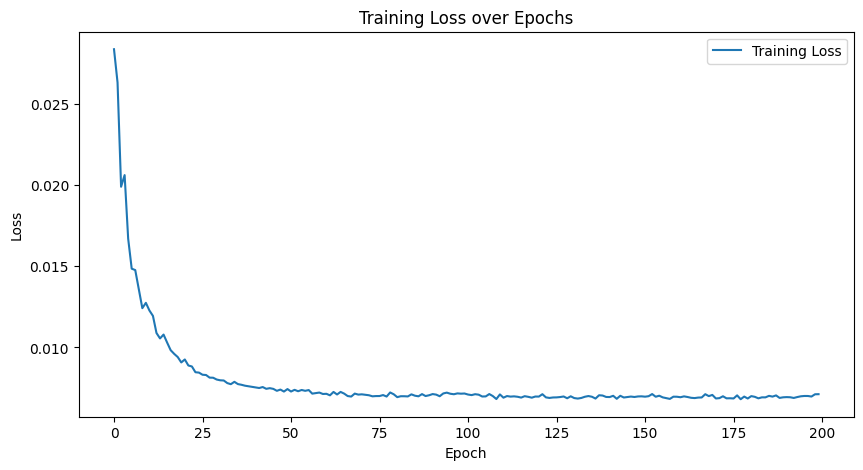

<ipython-input-14-3ce468642e8f>:114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)


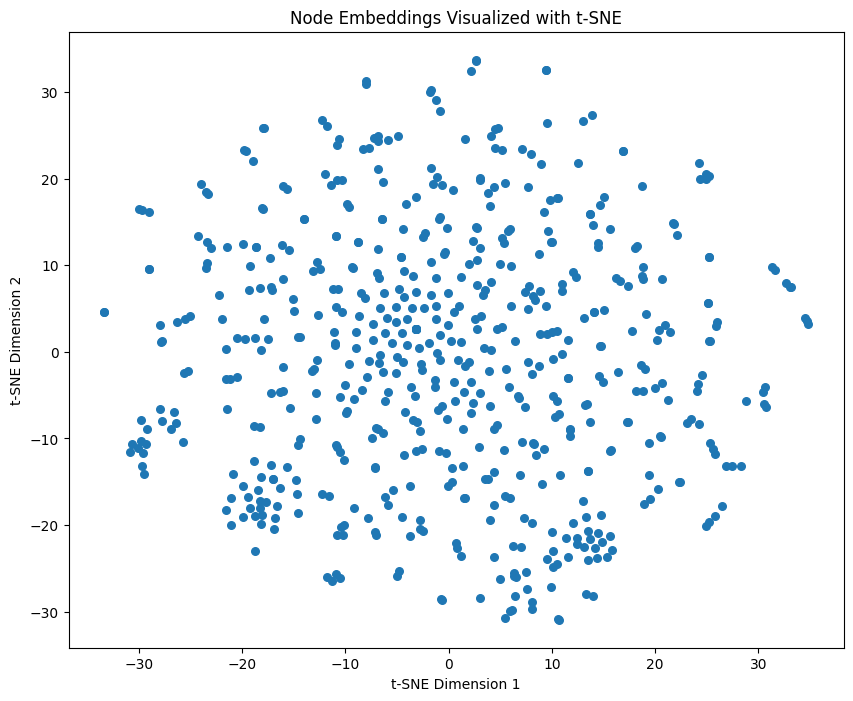

Reconstruction MSE Loss: 0.0063


In [14]:
import torch
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Step 1: Create a mapping from term to node index
terms = pd.concat([result_df['node_1'], result_df['node_2']]).unique()
term_to_index = {term: idx for idx, term in enumerate(terms)}

# Visualize Term-to-Node Mapping
print("\nTerm-to-Node Mapping:")
for term, idx in term_to_index.items():
    print(f"Term: {term}, Node Index: {idx}")

# Step 2: Convert term definitions into features (using TF-IDF for simplicity)
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(term_df['definition'].fillna('')).toarray()

# Create a feature matrix where each row corresponds to a term
features = np.zeros((len(terms), tfidf_features.shape[1]))
for idx, term in enumerate(term_df['term']):
    if term in term_to_index:
        term_idx = term_to_index[term]
        features[term_idx] = tfidf_features[idx]

# Convert features to a tensor
x = torch.tensor(features, dtype=torch.float)

# Step 3: Create the edge index and encode the relationship types
edges = []
edge_features = []
label_encoder = LabelEncoder()
encoded_relationships = label_encoder.fit_transform(result_df['edge'])

for idx, row in result_df.iterrows():
    if row['node_1'] in term_to_index and row['node_2'] in term_to_index:
        node1_idx = term_to_index[row['node_1']]
        node2_idx = term_to_index[row['node_2']]
        edges.append([node1_idx, node2_idx])
        edge_features.append(encoded_relationships[idx])

# Convert edge list and edge features to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)

# Step 4: Create the PyTorch Geometric Data object with edge attributes
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Step 5: Define the Graph Autoencoder model
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=2):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6, edge_dim=1)
        self.decoder = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        encoded = self.encoder(x, edge_index, edge_attr)
        encoded = F.elu(encoded)
        decoded = self.decoder(encoded, edge_index, edge_attr)
        return decoded, encoded

# Step 6: Initialize model and optimizer with optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoencoder(input_dim=data.num_features, hidden_dim=128, output_dim=data.num_features, heads=3).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    decoded, encoded = model(data.x, data.edge_index, data.edge_attr)
    loss = F.mse_loss(decoded, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
train_losses = []
for epoch in range(200):
    loss = train()
    train_losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Step 7: Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Step 8: Visualize the learned node embeddings using t-SNE
model.eval()
with torch.no_grad():
    _, embeddings = model(data.x, data.edge_index, data.edge_attr)
    embeddings = embeddings.cpu().numpy()

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)
plt.title('Node Embeddings Visualized with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Step 9: Evaluation Metric - Reconstruction Error (MSE on entire dataset)
model.eval()
with torch.no_grad():
    decoded, _ = model(data.x, data.edge_index, data.edge_attr)
    mse_loss = F.mse_loss(decoded, data.x).item()
    print(f'Reconstruction MSE Loss: {mse_loss:.4f}')


# USE

In [20]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 9.4 MB/s eta 0:00:00


Epoch 20, Loss: 0.0093
Epoch 40, Loss: 0.0076
Epoch 60, Loss: 0.0071
Epoch 80, Loss: 0.0071
Epoch 100, Loss: 0.0070
Epoch 120, Loss: 0.0070
Epoch 140, Loss: 0.0070
Epoch 160, Loss: 0.0070
Epoch 180, Loss: 0.0070
Epoch 200, Loss: 0.0069


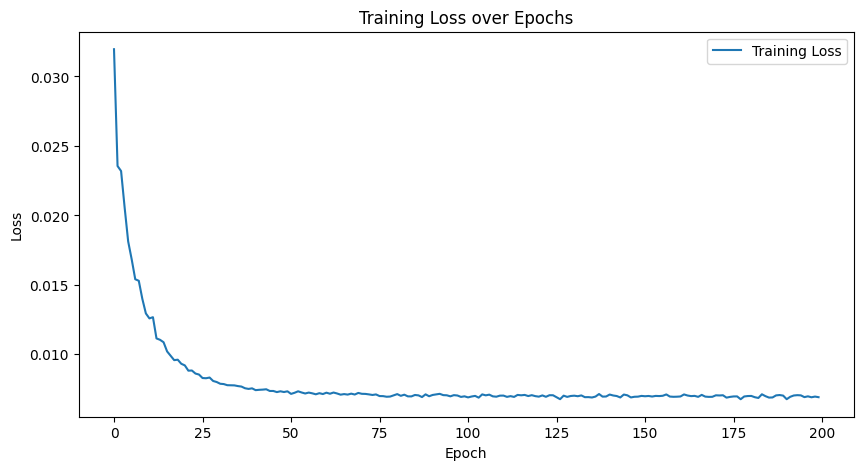

<ipython-input-21-fa7b0d2197e7>:120: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)


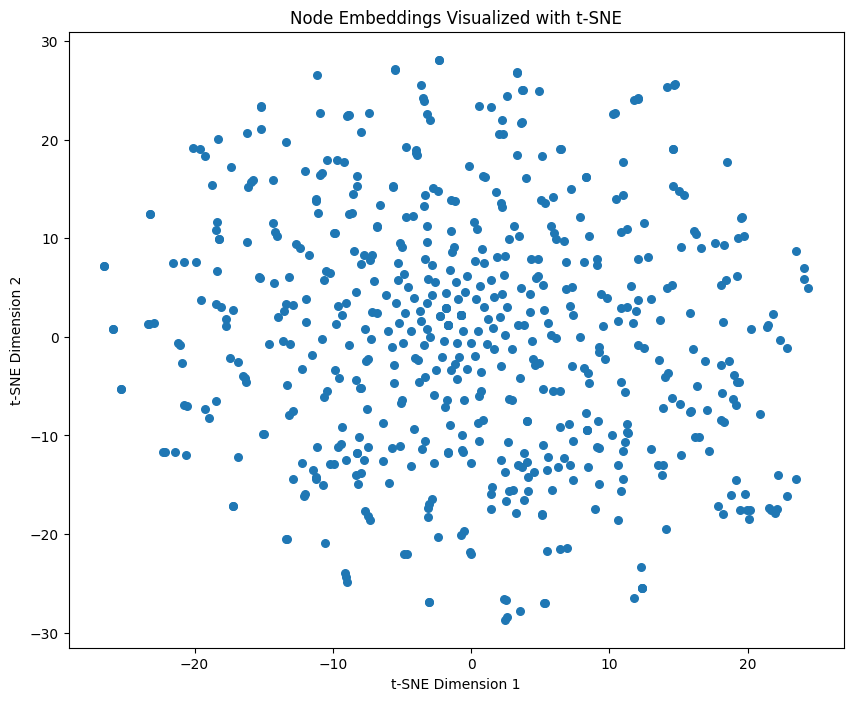

Reconstruction MSE on Test Set: 0.0057


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Top 3 matches for the query 'neural networks':
Term: group-based decision making, Definition: Seek to be a role model in areas of honesty, integrity, and ethical conduct. They focus on being transparent, behave unselfishly, and are able to ask for help. (Similarity: 0.1122)
Term: story map, Definition: the culmination of the other dimensions of emotional intelligence. It is concerned with managing groups of people, such as project teams, building social networks, finding common ground with various stakeholders, and building rapport. (Similarity: 0.1111)
Term: decentralized coordination, Definition: People in this function provide the knowledge, vision, and expertise in a specific subject for a project. They offer advice and (Similarity: 0.1029)


In [21]:
import torch
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Step 1: Create a mapping from term to node index
terms = pd.concat([result_df['node_1'], result_df['node_2']]).unique()
term_to_index = {term: idx for idx, term in enumerate(terms)}

# Step 2: Convert term definitions into features using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(term_df['definition'].fillna('')).toarray()

# Step 3: Create a feature matrix where each row corresponds to a term's embedding
features = np.zeros((len(terms), tfidf_features.shape[1]))
for idx, term in enumerate(term_df['term']):
    if term in term_to_index:
        term_idx = term_to_index[term]
        features[term_idx] = tfidf_features[idx]

# Convert features to a tensor
x = torch.tensor(features, dtype=torch.float)

# Step 4: Create the edge index and encode the relationship types
edges = []
edge_features = []
label_encoder = LabelEncoder()
encoded_relationships = label_encoder.fit_transform(result_df['edge'])

for idx, row in result_df.iterrows():
    if row['node_1'] in term_to_index and row['node_2'] in term_to_index:
        node1_idx = term_to_index[row['node_1']]
        node2_idx = term_to_index[row['node_2']]
        edges.append([node1_idx, node2_idx])
        edge_features.append(encoded_relationships[idx])

# Convert edge list and edge features to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)

# Step 5: Split the edges into train and test sets for evaluation
train_edges, test_edges, train_edge_attr, test_edge_attr = train_test_split(
    edge_index.t().numpy(), edge_attr.numpy(), test_size=0.2, random_state=42
)
train_edges, test_edges = torch.tensor(train_edges).t(), torch.tensor(test_edges).t()
train_edge_attr, test_edge_attr = torch.tensor(train_edge_attr), torch.tensor(test_edge_attr)

# Create train and test data objects
train_data = Data(x=x, edge_index=train_edges, edge_attr=train_edge_attr)
test_data = Data(x=x, edge_index=test_edges, edge_attr=test_edge_attr)

# Step 6: Define the Graph Autoencoder model
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=2):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6, edge_dim=1)
        self.decoder = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        encoded = self.encoder(x, edge_index, edge_attr)
        encoded = F.elu(encoded)
        decoded = self.decoder(encoded, edge_index, edge_attr)
        return decoded, encoded

# Step 7: Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoencoder(input_dim=train_data.num_features, hidden_dim=128, output_dim=train_data.num_features, heads=3).to(device)
train_data, test_data = train_data.to(device), test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

# Training function
def train(data):
    model.train()
    optimizer.zero_grad()
    decoded, encoded = model(data.x, data.edge_index, data.edge_attr)
    loss = F.mse_loss(decoded, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
train_losses = []
for epoch in range(200):
    loss = train(train_data)
    train_losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Step 8: Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Step 9: Visualize the learned node embeddings using t-SNE
model.eval()
with torch.no_grad():
    _, embeddings = model(train_data.x, train_data.edge_index, train_data.edge_attr)
    embeddings = embeddings.cpu().numpy()

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)
plt.title('Node Embeddings Visualized with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Step 10: Evaluation - Test Reconstruction MSE
model.eval()
with torch.no_grad():
    decoded_test, _ = model(test_data.x, test_data.edge_index, test_data.edge_attr)
    mse_loss = F.mse_loss(decoded_test, test_data.x).item()
    print(f'Reconstruction MSE on Test Set: {mse_loss:.4f}')



In [27]:
# Test the Q&A function
query_term = "process-based standard"  # Replace with any query term
query_definition(query_term, embeddings, list(term_to_index.keys()), term_df['definition'].fillna('').tolist())


Top 3 matches for the query 'process-based standard':
Term: batch size, Definition: geographical distribution of, 17 (Similarity: 0.1730)
Term: iteration review, Definition: Identifying areas where the project team is performing well and pointing out areas where the project team can improve helps the project team to grow. (Similarity: 0.1673)
Term: backlog, Definition: a process whereby modifications to documents, deliverables, or baselines associated with the project are identified and documented, and then are approved or rejected (Similarity: 0.1670)


In [5]:
!pip install umap

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x78fd8abb1fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces`

Epoch 20, Loss: 0.0021
Epoch 40, Loss: 0.0020
Epoch 60, Loss: 0.0020
Epoch 80, Loss: 0.0020
Epoch 100, Loss: 0.0020
Epoch 120, Loss: 0.0020
Epoch 140, Loss: 0.0020
Epoch 160, Loss: 0.0020
Epoch 180, Loss: 0.0020
Epoch 200, Loss: 0.0020
Epoch 220, Loss: 0.0020
Epoch 240, Loss: 0.0020
Epoch 260, Loss: 0.0020
Epoch 280, Loss: 0.0020
Epoch 300, Loss: 0.0020


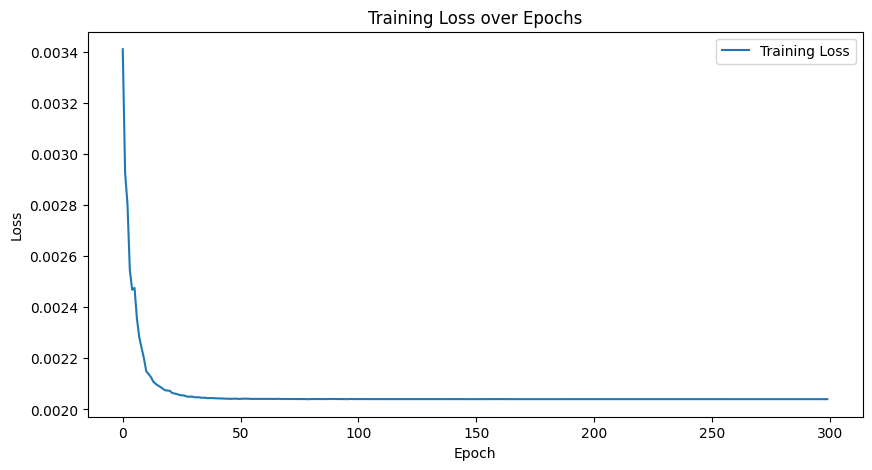

In [7]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import umap
import matplotlib.pyplot as plt



# Step 1: Create a mapping from term to node index
terms = pd.concat([result_df['node_1'], result_df['node_2']]).unique()
term_to_index = {term: idx for idx, term in enumerate(terms)}

# Ensure that all definitions are strings, replace NaN values with an empty string
term_df['definition'] = term_df['definition'].fillna('').astype(str)

# Step 2: Use Sentence-BERT to generate feature embeddings for terms
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose a larger model if needed

# Initialize feature matrix with the appropriate size
features = np.zeros((len(terms), 384))  # Assuming 384-dimensional embeddings from Sentence-BERT

# Populate feature matrix with embeddings
for idx, term in enumerate(term_df['term']):
    if term in term_to_index:
        term_idx = term_to_index[term]
        definition = term_df.loc[term_df['term'] == term, 'definition'].values[0]
        features[term_idx] = sentence_model.encode(definition)



# Convert features to a tensor
x = torch.tensor(features, dtype=torch.float)

# Step 3: Create the edge index and encode the relationship types
edges = []
edge_features = []
label_encoder = LabelEncoder()
encoded_relationships = label_encoder.fit_transform(result_df['edge'])

for idx, row in result_df.iterrows():
    if row['node_1'] in term_to_index and row['node_2'] in term_to_index:
        node1_idx = term_to_index[row['node_1']]
        node2_idx = term_to_index[row['node_2']]
        edges.append([node1_idx, node2_idx])
        edge_features.append(encoded_relationships[idx])

# Convert edge list and edge features to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)

# Step 4: Split the edges into train and test sets for evaluation
train_edges, test_edges, train_edge_attr, test_edge_attr = train_test_split(
    edge_index.t().numpy(), edge_attr.numpy(), test_size=0.2, random_state=42
)
train_edges, test_edges = torch.tensor(train_edges).t(), torch.tensor(test_edges).t()
train_edge_attr, test_edge_attr = torch.tensor(train_edge_attr), torch.tensor(test_edge_attr)

# Create train and test data objects
train_data = Data(x=x, edge_index=train_edges, edge_attr=train_edge_attr)
test_data = Data(x=x, edge_index=test_edges, edge_attr=test_edge_attr)

# Step 5: Define the deeper Graph Autoencoder model
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4, heads=4):
        super(GraphAutoencoder, self).__init__()

        # Encoder: Stack multiple GAT layers
        self.encoder_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim * heads
            self.encoder_layers.append(GATConv(in_dim, hidden_dim, heads=heads, dropout=0.6, edge_dim=1))

        # Decoder: Stack multiple GAT layers in reverse order
        self.decoder_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            out_dim = output_dim if i == num_layers - 1 else hidden_dim * heads
            self.decoder_layers.append(GATConv(hidden_dim * heads, out_dim, heads=1 if i == num_layers - 1 else heads, concat=False, dropout=0.6, edge_dim=1))

    def forward(self, x, edge_index, edge_attr):
        # Pass through encoder layers
        for layer in self.encoder_layers:
            x = F.elu(layer(x, edge_index, edge_attr))

        encoded = x  # Store encoded representation

        # Pass through decoder layers
        for layer in self.decoder_layers:
            x = F.elu(layer(x, edge_index, edge_attr)) if layer != self.decoder_layers[-1] else layer(x, edge_index, edge_attr)

        decoded = x  # Store decoded representation

        return decoded, encoded

# Step 6: Initialize model and optimizer with optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoencoder(input_dim=train_data.num_features, hidden_dim=128, output_dim=train_data.num_features, num_layers=4, heads=4).to(device)
train_data, test_data = train_data.to(device), test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)

# Training function
def train(data):
    model.train()
    optimizer.zero_grad()
    decoded, encoded = model(data.x, data.edge_index, data.edge_attr)
    loss = F.mse_loss(decoded, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
train_losses = []
for epoch in range(300):
    loss = train(train_data)
    train_losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Step 7: Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Step 8: Visualize the learned node embeddings using UMAP
model.eval()
with torch.no_grad():
    _, embeddings = model(train_data.x, train_data.edge_index, train_data.edge_attr)
    embeddings = embeddings.cpu().numpy()



In [6]:
!pip install umap-learn


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-8-05333defbbde>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)


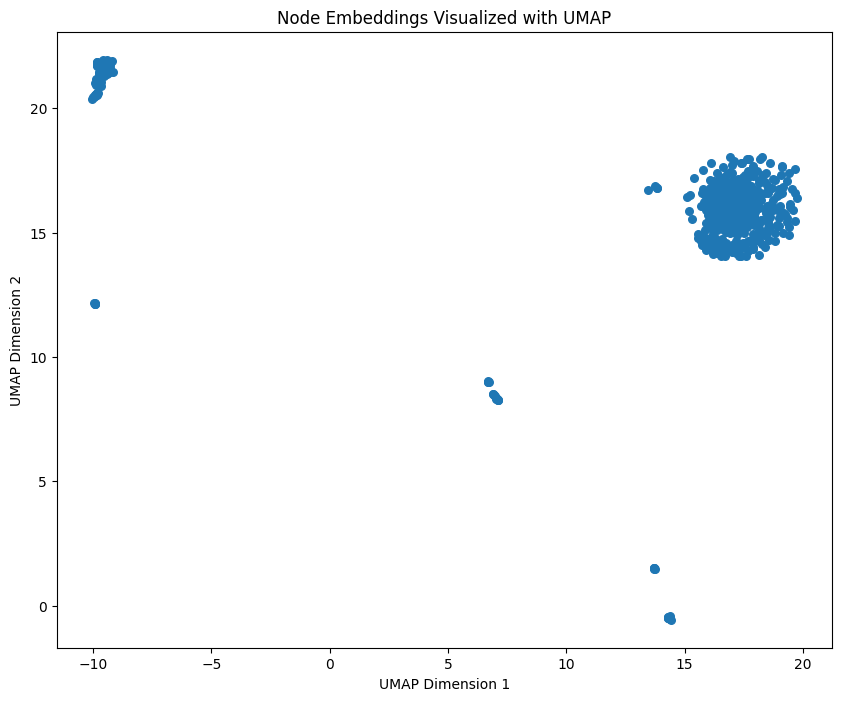

Reconstruction MSE on Test Set: 0.0020


In [8]:
import umap.umap_ as umap

# Apply UMAP for dimensionality reduction to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_model.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)
plt.title('Node Embeddings Visualized with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Step 9: Evaluation - Test Reconstruction MSE
model.eval()
with torch.no_grad():
    decoded_test, _ = model(test_data.x, test_data.edge_index, test_data.edge_attr)
    mse_loss = F.mse_loss(decoded_test, test_data.x).item()
    print(f'Reconstruction MSE on Test Set: {mse_loss:.4f}')


In [13]:
import torch
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load RoBERTa for question answering
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Step 3: Set up Sentence-BERT to encode the query
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  # Using the same Sentence-BERT model as before

def query_graph_with_qa(question, embeddings, terms, definitions, top_k=3):
    """
    Retrieve relevant terms and definitions for a given question and get precise answers using RoBERTa-QA.

    Parameters:
    - question (str): The user's question.
    - embeddings (np.array): Node embeddings from the Graph Autoencoder.
    - terms (list): List of terms corresponding to the embeddings.
    - definitions (list): List of definitions or context for each term.
    - top_k (int): Number of top matches to retrieve.

    Returns:
    - List of answers from the RoBERTa Q&A model.
    """
    # Step 4: Embed the question using Sentence-BERT
    query_embedding = sentence_model.encode([question])

    # Calculate cosine similarity between the query and all node embeddings
    similarity_scores = cosine_similarity(query_embedding, embeddings).flatten()

    # Get indices of top-k most similar nodes
    top_indices = similarity_scores.argsort()[::-1][:top_k]

    print(f"\nTop {top_k} relevant terms for the question '{question}':")
    answers = []
    for idx in top_indices:
        term = terms[idx]
        definition = definitions[idx]
        score = similarity_scores[idx]
        print(f"Term: {term}, Similarity: {score:.4f}")

        # Step 5: Use RoBERTa-QA on the term's definition to find the precise answer
        answer = qa_pipeline(question=question, context=definition)
        answers.append((term, answer['answer'], answer['score']))

        print(f"Answer: {answer['answer']} (Confidence: {answer['score']:.4f})")

    return answers

# Example Usage
# Assume `embeddings` contains node embeddings from GAE, `terms` is a list of terms, and `definitions` is a list of definitions
question = "What is the relation between Value delivery and Project?"  # Example question
query_graph_with_qa(question, embeddings, list(term_to_index.keys()), term_df['definition'].fillna('').tolist(), top_k=3)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 384 while Y.shape[1] == 512

In [15]:
import torch
import numpy as np
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import torch.nn.functional as F


# Step 1: Create a mapping from term to node index
terms = pd.concat([result_df['node_1'], result_df['node_2']]).unique()
term_to_index = {term: idx for idx, term in enumerate(terms)}

# Step 2: Use a 384-dimensional Sentence-BERT to generate feature embeddings for terms
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dimensional model

features = np.zeros((len(terms), 384))  # 384-dimensional embeddings
for idx, term in enumerate(term_df['term']):
    if term in term_to_index:
        term_idx = term_to_index[term]
        definition = term_df.loc[term_df['term'] == term, 'definition'].values[0]
        features[term_idx] = sentence_model.encode(definition)

# Convert features to a tensor
x = torch.tensor(features, dtype=torch.float)

# Step 3: Create the edge index and encode the relationship types
edges = []
edge_features = []
encoded_relationships = pd.factorize(result_df['edge'])[0]

for idx, row in result_df.iterrows():
    if row['node_1'] in term_to_index and row['node_2'] in term_to_index:
        node1_idx = term_to_index[row['node_1']]
        node2_idx = term_to_index[row['node_2']]
        edges.append([node1_idx, node2_idx])
        edge_features.append(encoded_relationships[idx])

# Convert edge list and edge features to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)

# Step 4: Define a deeper Graph Autoencoder model with 384 output dimensions
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, output_dim=384, num_layers=4, heads=4):
        super(GraphAutoencoder, self).__init__()
        self.encoder_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim * heads
            self.encoder_layers.append(GATConv(in_dim, hidden_dim, heads=heads, dropout=0.6, edge_dim=1))

        self.decoder_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            out_dim = output_dim if i == num_layers - 1 else hidden_dim * heads
            self.decoder_layers.append(GATConv(hidden_dim * heads, out_dim, heads=1 if i == num_layers - 1 else heads, concat=False, dropout=0.6, edge_dim=1))

    def forward(self, x, edge_index, edge_attr):
        for layer in self.encoder_layers:
            x = F.elu(layer(x, edge_index, edge_attr))
        encoded = x
        for layer in self.decoder_layers:
            x = F.elu(layer(x, edge_index, edge_attr)) if layer != self.decoder_layers[-1] else layer(x, edge_index, edge_attr)
        decoded = x
        return decoded, encoded

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoencoder().to(device)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)

# Training function
def train(data):
    model.train()
    optimizer.zero_grad()
    decoded, encoded = model(data.x, data.edge_index, data.edge_attr)
    loss = F.mse_loss(decoded, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
train_losses = []
for epoch in range(300):
    loss = train(data)
    train_losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Step 5: Set up RoBERTa for Q&A
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Query function to retrieve answers
def query_graph_with_qa(question, embeddings, terms, definitions, top_k=3):
    query_embedding = sentence_model.encode([question])
    similarity_scores = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = similarity_scores.argsort()[::-1][:top_k]

    print(f"\nTop {top_k} relevant terms for the question '{question}':")
    answers = []
    for idx in top_indices:
        term = terms[idx]
        definition = definitions[idx]
        score = similarity_scores[idx]
        print(f"Term: {term}, Similarity: {score:.4f}")

        answer = qa_pipeline(question=question, context=definition)
        answers.append((term, answer['answer'], answer['score']))

        print(f"Answer: {answer['answer']} (Confidence: {answer['score']:.4f})")

    return answers

# Example Usage
question = "What is the relation between Value delivery and Project?"
query_graph_with_qa(question, features, list(term_to_index.keys()), term_df['definition'].fillna('').tolist(), top_k=3)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 20, Loss: 0.0021
Epoch 40, Loss: 0.0020
Epoch 60, Loss: 0.0020
Epoch 80, Loss: 0.0020
Epoch 100, Loss: 0.0020
Epoch 120, Loss: 0.0020
Epoch 140, Loss: 0.0020
Epoch 160, Loss: 0.0020
Epoch 180, Loss: 0.0020
Epoch 200, Loss: 0.0020
Epoch 220, Loss: 0.0020
Epoch 240, Loss: 0.0020
Epoch 260, Loss: 0.0020
Epoch 280, Loss: 0.0020
Epoch 300, Loss: 0.0020


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Top 3 relevant terms for the question 'What is the relation between Value delivery and Project?':
Term: project environment, Similarity: 0.7473
Answer: governing portfolios, programs, and projects to focusing on the value chain (Confidence: 0.0376)
Term: business value, Similarity: 0.7420
Answer: WBS dictionary (Confidence: 0.0001)
Term: general management principles, Similarity: 0.7060
Answer: performance (Confidence: 0.0011)


[('project environment',
  'governing portfolios, programs, and projects to focusing on the value chain',
  0.03757855296134949),
 ('business value', 'WBS dictionary', 5.8536552387522534e-05),
 ('general management principles', 'performance', 0.001065366086550057)]

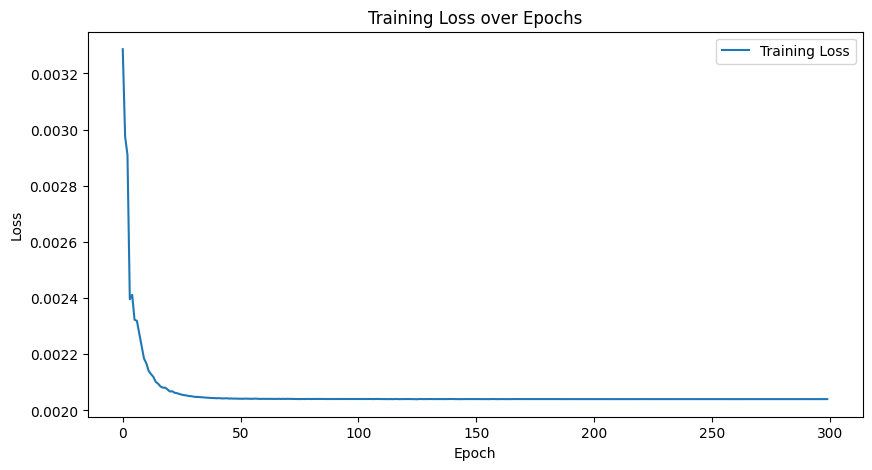

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-16-15e0e414aab5>:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)


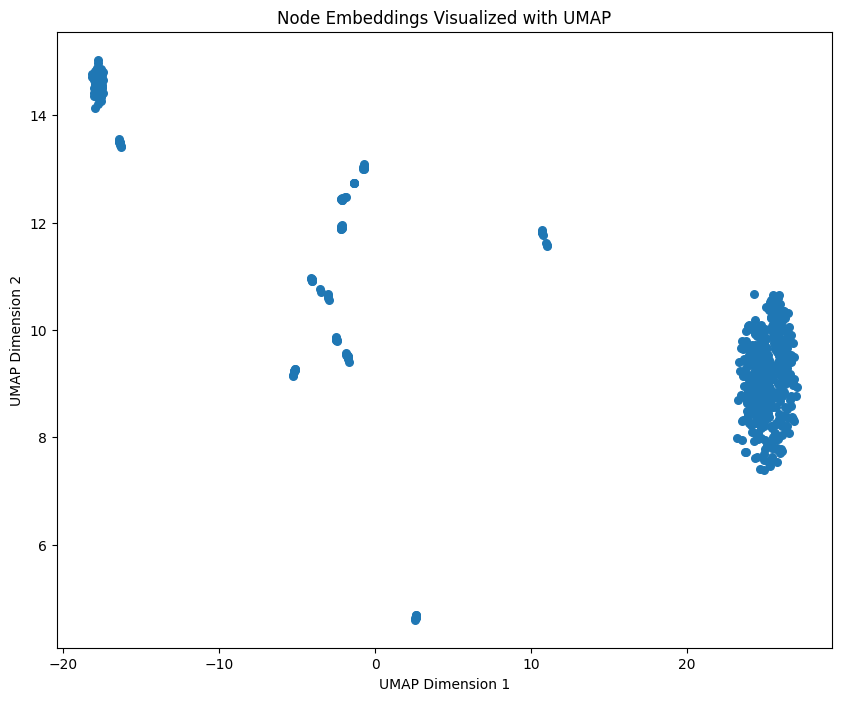

Reconstruction MSE on Test Set: 0.0020


In [16]:
# Step 7: Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Step 8: Visualize the learned node embeddings using UMAP
model.eval()
with torch.no_grad():
    _, embeddings = model(train_data.x, train_data.edge_index, train_data.edge_attr)
    embeddings = embeddings.cpu().numpy()

import umap.umap_ as umap

# Apply UMAP for dimensionality reduction to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_model.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap='viridis', s=30)
plt.title('Node Embeddings Visualized with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Step 9: Evaluation - Test Reconstruction MSE
model.eval()
with torch.no_grad():
    decoded_test, _ = model(test_data.x, test_data.edge_index, test_data.edge_attr)
    mse_loss = F.mse_loss(decoded_test, test_data.x).item()
    print(f'Reconstruction MSE on Test Set: {mse_loss:.4f}')


In [19]:
# Example Usage
question = " Project management"
query_graph_with_qa(question, features, list(term_to_index.keys()), term_df['definition'].fillna('').tolist(), top_k=3)



Top 3 relevant terms for the question ' Project management':
Term: cost management plan, Similarity: 0.7965
Answer: The project vision (Confidence: 0.0001)
Term: tailoring, Similarity: 0.7562
Answer: practices have value and usefulness. (Confidence: 0.0000)
Term: process groups, Similarity: 0.7452
Answer: stakeholder concerns interact throughout the performance domains (Confidence: 0.0000)


[('cost management plan', 'The project vision', 8.04770752438344e-05),
 ('tailoring', 'practices have value and usefulness.', 3.1031206617626594e-06),
 ('process groups',
  'stakeholder concerns interact throughout the performance domains',
  1.731030785379062e-08)]